# Solutions to Problem Set 7: Bits-Back Coding With a Latent Variable Model

**Course:** Data Compression With And Without Deep probabilistic models (Prof. Robert Bamler at University of Tuebingen)

- This notebook is part of Problem Set 7, published on 3 June 2022 and discussed on 24 June 2022.
- Download the full problem set (and solutions) from the [course website](https://robamler.github.io/teaching/compress22/).

This problem set guides you through the implementation of the bits-back trick that we covered in the lecture.
We will use a toy example model here, but the same technique that we use here is also applied in the literature to powerful deep latent variable models such as hierarchical variational autoencoders (discussed in the lecture on June 23), both for lossy and lossless compression.

## Overview of the Problem Set

This problem set consists of five problems.
Problem 7.1 covers all the prep work: we'll introduce a latent variable model for a hypothetical data source, we'll generate some artificial test data, and we'll install an external library that will ultimately take care of entropy coding in the subsequent problems.
Problems 7.2-7.4 then guide you step by step through the implementation of three different compression techniques:

- in Problem 7.2, you'll implement a naive compression method that simply ignores correlations between symbols in a message;
- in Problem 7.3, you'll encode and transmit a MAP estimated latent variable, and then encode the message conditioned on the MAP estimate; and
- in Problem 7.4, you'll improve on the method from Problem 7.3 by using the bits-back trick.

Finally, in problem 7.5, you will compare the bit rates of the above three compression methods empirically, and you will discuss and explain their differences.
**This discussion in Problem 7.5 is the most important part of this problem set.**
Use this discussion to test your understanding: once you worked through this problem set and implemented all three compression methods, you should be able to answer all questions in Problem 7.5.

## Problem 7.1: Prerequisites

You won't yet write much code in this problem, we'll just set up everything here so that you can get your hands dirty in Problems 7.2-7.4 below.

### Problem 7.1 (a): a library of entropy coding primitives

On this problem set, we'll focus on the interplay between data compression and probabilistic model architectures.
In other words, we'll address the question "which random variables have to be encoded or decoded with which probabilistic models and in which order?".
Once we've figured this out, we'll delegate the actual task of encoding and decoding the symbols to a third party library that provides the ANS algorithm (which we also discussed and implemented in class).

We'll use the [`constriction` library](https://bamler-lab.github.io/constriction/), which we already used in Problem 6.3 on the last problem set, but this time we'll use `constriction`'s ANS coder rather than its range coder (please [report issues](https://github.com/bamler-lab/constriction/issues) if you run into problems with `constriction`).

To install `constriction`, execute the following cell:

In [1]:
import sys
!{sys.executable} -m pip install constriction~=0.2.4 matplotlib

Defaulting to user installation because normal site-packages is not writeable


Now, test `constriction` by running the example code below.
Carefully read the example code and make sure you understand how the showcased parts of the library are used.

In [2]:
import constriction
import numpy as np

# Specify a probabilistic model of a data source (typically referred to as an
# "entropy model"). We'll use a categorical distribution with P(X=0) = 0.3,
# P(X=1) = 0.4, P(X=2) = 0.2, and P(X=3) = 0.1 in this example.
probs = np.array([0.3, 0.4, 0.2, 0.1], dtype=np.float64) # (must be float64)
entropy_model = constriction.stream.model.Categorical(probs)

# Define two example messages; symbols must be 32-bit signed integers within the
# range from zero (inclusively) to `len(probs)` (exclusively).
message1 = np.array([3, 0, 1, 0, 2, 3, 2, 2], dtype=np.int32)
message2 = np.array([1, 3, 2, 1, 3], dtype=np.int32)

# Construct an entropy coder that uses the Asymmetric Numeral Systems (ANS)
# method that we introduced in class. Then encode both example messages using
# the coder and the entropy model.
#
# Please note:
# - we encode both messages with the same entropy model here for simplicity, but
#   you could also use a different entropy model for each message, as long as
#   you use the same models for encoding and decoding (see exercise below); and
# - when you construct `coder` below, you could also provide some initial bit
#   string to the constructor; encoding would then *append* to this bit string.
coder = constriction.stream.stack.AnsCoder()
coder.encode_reverse(message2, entropy_model) # We encode `message2` before
coder.encode_reverse(message1, entropy_model) # `message1` since ANS is a stack.

# Get the compressed data as an array of unsigned 32-bit integers (this is how
# the `constriction` library represents compressed data by default).
compressed = coder.get_compressed()
print(f'bit rate: {len(compressed)*32} (includes padding to a multiple of 32).')
print(f'compressed: {compressed}') # should print: "[3521629398     430756]"

# Create a decoder and decode the messages.
# Please note:
# - we're *popping the messages off the stack*, so we'll first get `message1`
#   and then `message2`;
# - the `AnsCoder` class actually doesn't distinguish between an encoder and a
#   decoder, i.e., you could also use the original `coder` for decoding; and
# - the second argument to the method `decode` is the number of symbols you want
#   to decode (if you leave out this argument you'll decode a single symbol).
decoder = constriction.stream.stack.AnsCoder(compressed)
reconstruction1 = decoder.decode(entropy_model, 8) # (decodes 8 i.i.d. symbols)
reconstruction2 = decoder.decode(entropy_model, 5) # (decodes 5 i.i.d. symbols)

# Verify correctness.
assert np.all(reconstruction1 == message1)
assert np.all(reconstruction2 == message2)
print('Both messages reconstructed successfully.')

# An `AnsCoder` encapsulates a compressed bit string. Encoding symbols *appends*
# data to the encapsulated bit string and decoding symbols *consumes* data from
# the encapsulated bit string (with "stack" semantics). Thus, once you've
# decoded all symbols, the encapsulated bit string is empty:
assert len(decoder.get_compressed()) == 0

bit rate: 64 (includes padding to a multiple of 32).
compressed: [3521629398     430756]
Both messages reconstructed successfully.


#### Your Task:

To verify that you understand how the library works, change the above example so that it still encodes both `message1` and `message2`, but now with *different* entropy models.
While `message1` should be encoded and decoded as before, `message2` should now be encoded and decoded with a model that supports only the alphabet $\{1, 2, 3\}$ (i.e., it doesn't support the symbol "$0$"), and the probabilities are $P(X_i=1)=0.5$, $P(X_i=2)=0.2$, and $P(X_i=3)=0.3$.
Your implementation should print the compressed representation as being `[2884514895      59071]`, and it should then be able to successfully reconstruct both messages.

*Hint:*
`constriction.stream.model.Categorical` can only model distributions over a range of symbols that starts at zero.
So you'll have to define a categorical probability distribution over the alphabet $\{0, 1, 2\}$ and encode `message2 - 1` instead of `message2`.
And when you decode the message, use `reconstruction2 = decoder.decode(...) + 1`.

If you want to play around more with the `constriction` library then you may want to refer to its [API documentation](https://bamler-lab.github.io/constriction/apidoc/python/).

#### Proposed Solution:

In [3]:
import constriction
import numpy as np

probs1 = np.array([0.3, 0.4, 0.2, 0.1], dtype=np.float64) # (must be float64)
probs2 = np.array([0.5, 0.2, 0.3], dtype=np.float64)      # (must be float64)
entropy_model1 = constriction.stream.model.Categorical(probs1)
entropy_model2 = constriction.stream.model.Categorical(probs2)

message1 = np.array([3, 0, 1, 0, 2, 3, 2, 2], dtype=np.int32)
message2 = np.array([1, 3, 2, 1, 3], dtype=np.int32)

coder = constriction.stream.stack.AnsCoder()
coder.encode_reverse(message2 - 1, entropy_model2)
coder.encode_reverse(message1, entropy_model1)

compressed = coder.get_compressed()
print(f'bit rate: {len(compressed)*32} (includes padding to a multiple of 32).')
print(f'compressed: {compressed}') # should print: "[2884514895      59071]"

decoder = constriction.stream.stack.AnsCoder(compressed)
reconstruction1 = decoder.decode(entropy_model1, 8)
reconstruction2 = decoder.decode(entropy_model2, 5) + 1

assert np.all(reconstruction1 == message1)
assert np.all(reconstruction2 == message2)
print('Both messages reconstructed successfully.')

assert len(decoder.get_compressed()) == 0

bit rate: 64 (includes padding to a multiple of 32).
compressed: [2884514895      59071]
Both messages reconstructed successfully.


### Problem 7.1 (b): Latent Variable Model

Now, let's set up everything we need for Problems 7.2-7.4 below, where you will implement three different compression techniques.

The first step is to define a probabilistic model of a data source.
We will use a very simple probabilistic model so that you can focus on the coding techniques and you don't get distracted by complicated model architectures.
Unfortunately, this means that our example model is somewhat contrived.
Don't get discouraged by this!
The same techniques that you will learn at the example of this toy model have recently been applied to powerful deep learning models such as variational autoencoders (which we'll cover in the lecture on June 23), resulting in some of the most competitive image and video compression methods.
Trying out the same techniques on a simplified toy model will allow you to easily change parameters so that you can explore why certain methods work better or worse in different regimes (see Problem 5.5 below).

We consider messages $\mathbf x=(x_1,x_2,\ldots,x_k)$ that are sequences of $k$ binary symbols, $x_i \in\{0, 1\}\;\forall i\in\{1,\ldots,k\}$, where the message length $k$ is known to both the sender and the receiver.
Our probabilistic model of the data source assumes that each symbol $x_i$ was generated by throwing a die and then setting:

$$
    x_i = \begin{cases}
        1 & \text{if the die throw resulted in $1$, $2$, $3$, $4$, or $5$} \\
        0 & \text{otherwise.}
    \end{cases}
$$

However, the die that is used to generate these symbols is not a standard six-sided die.
Instead, it is a fair $z$-sided die, where $z$ can be any integer between $10$ and $60$ (both inclusively).
Importantly, the value of $z$ is *not* part of the message, but it is the *same for all symbols $x_i$ within one message* (but can be different for different messages).
In this sense, $z$ is similar to the latent "topic" of the newspaper headlines that we discussed in the lecture, which was also not part of the message and assumed to be the same for all words in any given headline.

Thus, the probabilistic model $P(\mathbf X)$ of the messages $\mathbf X$ results from *marginalizing over a latent variable $Z\in\{10,\ldots,60\}$* in a joint probability distribution $P(\mathbf X, Z)$, i.e.,

$$
    P(\mathbf X) = \sum\limits_{z=10}^{60} P(\mathbf X, Z=z)
$$
where the joint probability distribution factorizes as follows,
$$
    P(\mathbf X, Z) = P(Z) \, P(\mathbf X|Z) = P(Z)\, \prod\limits_{i=1}^k P(X_i |Z).
$$

We assume that we have no prior knowledge about the value of $Z$ (apart from the fact that it is in the range from $10$ to $60$).
In statistics speak, this means that the so-called prior distribution $P(Z)$ is the distribution over $\{10,\ldots,60\}$ with maximum entropy, i.e., the *uniform* distribution,
$$
    P(Z=z) = \frac{1}{51} \qquad\text{for all $z\in\{10,\ldots,60\}$}.
$$

The likelihood $P(X_i|Z)$ follows from the die-throwing process described above, i.e.,
$$
    P(X_i=x_i\, |\, Z=z) = \begin{cases}
        \frac{5}{z} & \text{if $x_i=1$;} \\[3pt]
        \frac{z-5}{z} & \text{if $x_i=0$.}
    \end{cases}
$$

The following code defines the prior and likelihood.
Read it carefully and make sure you understand what both functions do and why they match the above mathematical definitions.

In [4]:
import numpy as np
import constriction
import matplotlib.pyplot as plt

In [5]:
domain_z = np.arange(10, 60 + 1)
domain_x = np.array([0, 1])

def prior(z):
    prior_probability = 1 / len(domain_z)
    if isinstance(z, np.ndarray):
        # If `z` is an array then return an array with the prior probability of
        # each element of `z` (which is always simply `1 / len(domain_z)`).
        return np.full(z.shape, prior_probability)
    else:
        return prior_probability

def likelihood(x, z):
    # The following line acts like an `if` statement but it also works if `x` is
    # an array of symbols rather than a single symbol (in which case it returns
    # an array whose elements are the likelihood of each `x[i]`).
    return (x * 5 + (1 - x) * (z - 5)) / z

#### Verify Model Correctness and Generate Toy Data

It's always a good idea to check empirically if we've made any obvious mistake in the model definition (like missing a prefactor, etc.).
We want to catch such mistakes early because they will be very hard to detect later on (even if we made a mistake in the model definition, it's possible that all the compression methods on top of it will still technically work, they will just perform worse than they could).

A simple way to check for obvious errors in the model definition is to implement the generative process *in the most naive way possible* (so that you can be sure it's correct), generate some random samples from the model, plot histograms of these random samples, and then just visually compare the histograms to the model.
As a side effect of this, we also get some toy data that we will later use to test our compression methods.

**Note:** We only test the *likelihood* here, i.e., we pretend that we know the value of the latent variable $Z$. In the full problem, we assume that at least the receiver *doesn't* know the value of $Z$.

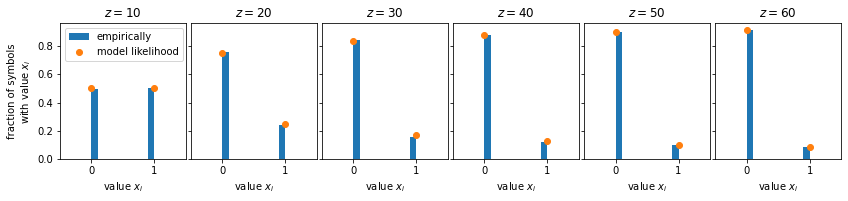

In [6]:
rng = np.random.RandomState(123) # Set a random seed to make tests reproducible.

num_samples_per_z = 10000
samples_x = np.empty((len(domain_z), num_samples_per_z), dtype=np.int32)
fig, axs = plt.subplots(1, (len(domain_z)+9)//10, figsize=(14,2.5), sharey=True)

for z_index, z in enumerate(domain_z):
    # Generate some samples from the likelihood P(X_i|Z=z) in the most straight-
    # forward way possible so that we can be confident there's no bug here.
    for i in range(num_samples_per_z):
        # Note: `rng.choice(z)` returns a value from 0 to `z-1`.
        samples_x[z_index, i] = 1 if rng.choice(z) < 5 else 0
    
    if z_index % 10 == 0:
        # Plot the likelihood for every 10th value of z.
        ax = axs[z_index // 10]
        ax.set_title(f'$z = {z}$')
        ax.hist(samples_x[z_index], label='empirically',
            weights=[1/num_samples_per_z] * num_samples_per_z)
        ax.plot([0, 1], likelihood(domain_x, z), 'o', label='model likelihood')
        ax.set_xlabel('value $x_i$')
        ax.set_xlim(-0.5, 1.5)
        ax.set_xticks([0, 1])
        ax.set_xticklabels([0, 1])

axs[0].set_ylabel('fraction of symbols\nwith value $x_i$')
axs[0].legend(loc='upper left')
    
fig.subplots_adjust(wspace=0.04)

#### Your Task

Look at the above graphs and make sure you understand what they show (you'll probably have to refer to the code for this purpose).
Then make sure that you understand why the graphs are consistent with what we expect from the model.

In particular, you should notice:

- that the models (organge dots) match the empirical distributions (blue bars) up to small deviations (some amount of noise should be expected);
- that the likelihood for $z=10$ looks like it's symmetric; why is this what we expect for the case $z=10$?
- that, for increasing $z$, both the empirical distribution and the model likelihood start to favor the symbol "0"; why is this, too, consistent with our expectation?

### Problem 7.1 (c): Test Harness

As a final setup step before we can do get to the interesting parts, the following code defines a generic function that we'll use to test and benchmark the three compression methods we'll implement in Problems 7.2-7.4.
Read the doc string and make sure you understand it, then move on to Problem 7.2, where you'll finally implement the first compression method.

In [7]:
def test_compression_method(encode, decode, message_length=100):
    """Verify correctness and evaluate compression performance.

    This function encodes several random messages from the model into a single
    bit string by repeatedly calling the provided callback `encode`. It then
    decodes all messages from the resulting compressed bit string by repeatedly
    calling the provided callback `decode`, and it verifies that all decoded
    messages match the original messages. The function returns the average bit
    rate per symbol (averaged over all symbols in all test messages).

    Thus, this function simulates a real-world scenario where you'd typically
    use a single channel to communicate several messages. All sample messages
    are *independent* draws from the probabilistic model. Thus, while the
    symbols *within each message* are all generated with the same latent $z$,
    the value of $z$ can differ across messages. Therefore, the *concatenation*
    of the sample messages would *not* be distributed according to the
    probabilistic model. Again, this simulates the typical real-world scenario:
    if you were to communicate, e.g., a sequence of images, then you'd expect
    each individual image to show some scene, but it would be unreasonable to
    assume that the concatenation of all images would also show a single scene.

    Args:
        encode: function with signature `encode(message, existing_compressed)`.
            When called, the function should compress `message` by appending a
            compressed representation of it to `existing_compressed` and return
            the resulting (now longer) compressed bit string.
        decode: a function with signature `decode(compressed, message_length)`.
            The function should decode a message of length `message_length`
            from the *end* of the bit string `compressed` and return a tuple
            `(message, remaining)`, where `message` is the decoded message and
            `remaining` is any part of the original bit string `compressed` that
            is left over after decoding.
        message_length: the number of symbols per message (defaults to 100).

    Returns:
        float: the average bit rate per symbol.
    """

    assert message_length <= samples_x.shape[1]

    # Compress the messages, starting with no compressed data, and growing the
    # buffer of compressed data in each step.
    # [Technical note: this function is for demonstration purpose; in a real
    # application, you'd want to pass around `AnsCoder`s instead of raw
    # compressed data so that the `encode` callback doesn't have to copy
    # compressed data into and out of an `AnsCoder` all the time.]
    compressed = np.array([], dtype=np.uint32)
    for i, z in enumerate(domain_z):
        compressed = encode(samples_x[i, :message_length], compressed)

    # The bit string `compressed` is represented as an array of 32-bit integers.
    total_bitrate = len(compressed) * 32

    # Decompress the data and verify that we reconstruct the original messages.
    # We iterate *in reverse order* since we assume that the encoder-decoder
    # pair that the caller provided operates as a stack.
    for i, z in reversed(list(enumerate(domain_z))):
        reconstructed, compressed = decode(compressed, message_length)
        assert np.all(reconstructed == samples_x[i, :message_length])

    return total_bitrate / (message_length * len(domain_z))

## Various Compression Techniques

Problems 7.2-7.4 below make up the main part of this problem set.
You'll implement three different techniques to encode data from the data source defined in Problem 7.1 (b) above.
You'll start with a trivial technique in Problem 7.2 and then gradually increase the complexity in Problems 7.3 and 7.4.
In Problem 7.5, you'll compare the empirical compression performances of these three techniques.

## Problem 7.2: Compressing Without Exploiting Correlations

### Problem 7.2 (a): Define a Simplified Model of the Data Source

Our simplest compression technique just ignores any correlations between the symbols $X_i$ that result from the marginalization over the latent variable $Z$.
Thus, while the data that we want to compress will still come from the probability distribution $P$ defined in Problem 7.1 (b) above, we don't actually use this probability distribution as our entropy model for compression for now.
Instead, we use a simplified model $P'$ that factorizes over all symbols,
$$
    P'(\mathbf{X}) = \prod_{i=1}^k P'(X_i)
$$
and we simply encode all messages by encoding each symbol independently with the entropy model $P'$.
We therefore don't even have to encode and transmit any value of $Z$ to the receiver.

#### Your Tasks:

1. Remind yourself that, within the constraints of such a fully factorized model, the optimal probability distribution $P'(X_i)$ for each symbol is the *marginal* probability under the model, i.e., $P'_\text{optimal}(X_i) = P(X_i) \equiv \sum_{z=10}^{60} P(Z=z) P(X_i|Z=z)$. Refer to Problem 5.2 (a) from last week's problem set if this is not clear to you.
2. Implement the function `marginal_symbol_probability` below and verify that it returns the correct result when applied to `domain_x`, as indicated in the comment below.

In [8]:
def marginal_symbol_probability(x):
    # YOUR TASK: marginalize $P(Z, X_i=x) = P(Z) P(X_i=x|Z)$ over all $Z$ in
    # `domain_z` and return the resulting marginal probability $P(X_i=x)$.
    # If `x` is an array of symbols rather than a single symbol, then calculate
    # P(X_i=x[i])$ for each array entry `x[i]` and return an array of the
    # results. (about 4 lines of code)

    # PROPOSED SOLUTION:
    accum = 0
    for z in domain_z:
        accum += prior(z) * likelihood(x, z)
    return accum

In [9]:
# This should return `array([0.818539, 0.181461])`.
marginal_symbol_probability(domain_x)

array([0.818539, 0.181461])

Looks reasonable, it's somewhere between the two extreme cases for $z=10$ and $z=60$ in the plots from Problem 7.1 (b) above.

### Problem 7.2 (b): Implement and Test the Encoder and Decoder

#### Your Task:

Now, let's get real!
Implement functions `encode_independently` and `decode_independently` that encode and decode a message by using the marginal probability distribution $P(X_i)$ for each symbol, which you calculated above.
These methods should behave as described in the doc string of the function `test_compression_method` (see Problem 7.1 (c) above).
You may find it useful to refer back to Problem 7.1 (a) to refresh your memory of how to construct an `AnsCoder` with some existing compressed data, how to encode and decode some symbols with it, and how to get the compressed data out of an `AnsCoder`.

Once you've implemented both the encoder and the decoder, run the unit test as indicated below and make sure that it passes.

In [10]:
def encode_independently(message, existing_compressed):
    # YOUR TASK: fill in the function body (about 3-5 lines of code)

    # PROPOSED SOLUTION:
    coder = constriction.stream.stack.AnsCoder(existing_compressed)
    probs = marginal_symbol_probability(domain_x)
    model = constriction.stream.model.Categorical(probs)
    coder.encode_reverse(message, model)
    return coder.get_compressed()

def decode_independently(compressed, message_length):
    # YOUR TASK: fill in the function body (about 3-5 lines of code)

    # PROPOSED SOLUTION:
    coder = constriction.stream.stack.AnsCoder(compressed)
    probs = marginal_symbol_probability(domain_x)
    model = constriction.stream.model.Categorical(probs)
    decoded = coder.decode(model, message_length)
    return decoded, coder.get_compressed()

In [11]:
# This should run without raising an exception and return an average
# bit rate of about 0.69 bits per symbol.
test_compression_method(encode_independently, decode_independently)

0.6901960784313725

## Problem 7.3: Compressing With a Maximum A-Posteriori (MAP) Estimate of $Z$

In this problem, you will encode the message $\mathbf{x}=(x_1,x_2,\ldots,x_k)$ with a more accurate model than the simplified model $P'$ from Problem 5.2.
To do this, you will exploit the fact that the stochastic process that generated the message used the *same* value $z$ of the latent variable $Z$ for generating all symbols $x_i$ within any given message.
Thus, if we know $z$, then the likelihood $P(X_i|Z=z)$ should be a better model for encoding each symbol in a message than $P'(X_i)$.

Unfortunately, the receiver doesn't know which $z$ was used to generate the message.
Thus, you'll have to encode and transmit not only the message $\mathbf x$ but also a value $z$ for the latent variable $Z$ (even though $z$ is not part of the message).
But which value $z$ should you encode?
First off, the *sender* might know the *true* value of $Z$ that was used during the generation of the message (depending on the circumstances of how our compression method gets deployed).
But this "ground truth" value of $Z$ is actually irrelevant here because it is not part of the message and so we don't care about transmitting it.
We only care about transmitting the message $\mathbf x$, and about making the compressed representation as short as possible.
Thus, we should set $Z=z^*$, where $z^*$ is not necessarily the ground truth value of $Z$ but instead the one that results in the shortest total bit rate when using the above described encoding scheme.
As we discussed in the lecture, we get $z^*$ by minimizing the *joint* information content of $Z$ and the given message $\mathbf x$ over $Z$,
$$
    z^* = \arg\min_z \big[-\log P(\mathbf X=\mathbf x, Z=z) \big]
    = \arg\max_z \left[ \log P(Z=z) + \sum_{i=1}^k \log P(X_i=x_i \, |\, Z=z) \right].
$$

Note that:

- The logarithm may *seem* unnecessary for taking the $\arg\max$, but it is important in practice because it prevents numerical underflow as $P(\mathbf X=\mathbf x\,|\, Z=z) = \prod_{i=1}^k P(X_i=x_i\,|\,Z=z)$ is exponentially small in $k$.)
- As discussed in the lecture, the solution $z^*$ is also called the *maximum a-posteriori* (MAP) solution since maximizing the joint distribution $P(\mathbf X=\mathbf x, Z)$ over all possible values of $Z$ is equivalent to maximizing the *posterior distribution*, $P(Z\, |\, \mathbf{X}=\mathbf{x}) = P(\mathbf X=\mathbf x, Z)\,/\, P(\mathbf X=\mathbf x)$ (because the posterior and the joint only differ by the positive factor $P(\mathbf X=\mathbf x)$, which is a constant for any given message $\mathbf x$).

#### Your tasks:

1. Implement the function `map_estimate` below, which takes a `message` (i.e., $\mathbf x$) and returns $z^*$.
2. Make sure you didn't make any obvious mistake by running the code below that tests `map_estimate` on some of our sample messages and generates a visualization of the results.
3. Then implement an encoder and decoder (similar to Problem 7.2) and test them.
   - Remember that, in this problem, you have to transmit both the message $\mathbf x$ and the latent variable $z^*$, and you'll need to use different entropy models for the two (use the prior $P(Z)$ to encode $z^*$ and the likelihood $P(X_i|Z=z^*)$ to encode each symbol in the message). You should have experience in this kind of task from solving Problem 7.1 (a).
   - Also remember that the `AnsCoder` that we're using here is a *stack*. So you'll have to encode first $\mathbf x$ and then $z^*$ because the decoder will have to decode $z^*$ first so it can use it to calculate the likelihood $P(X_i|Z=z^*)$ for decoding $\mathbf x$. (For the current problem, you could also use a range coder, which operates as a *queue* as discussed in the lecture on 19 May, but Problem 7.4 below will be much easier to solve with a stack; the `constriction` library provides a range coder implementation whose API is very similar to that of the `AnsCoder`; if you're curious, refer to the [API documentation for range coding](https://bamler-lab.github.io/constriction/apidoc/python/stream/queue.html))

In [12]:
def log_joint_probability(message, z):
    # This is already provided for you. You don't need to change it.
    # (But you should understand it.)
    return np.log(prior(z)) + np.sum(np.log(likelihood(message, z)))

def map_estimate(message):
    # YOUR TASK: fill in the function body (about 4 lines of code)

    # PROPOSED SOLUTION:
    log_joints = [log_joint_probability(message, z) for z in domain_z]
    return domain_z[np.argmax(log_joints)]

Check that you didn't make any obvious mistake:

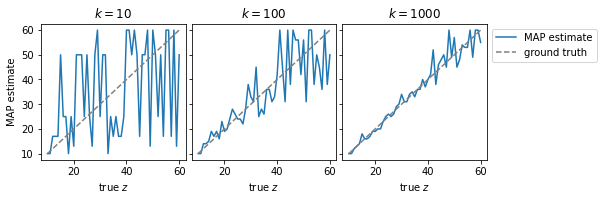

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(8, 2.5), sharey=True)

for ax, message_length in zip(axs, [10, 100, 1000]):
    map_estimates = [map_estimate(samples_x[i, :message_length])
                     for i in range(len(domain_z))]
    ax.set_title(f'$k={message_length}$')
    ax.plot(domain_z, map_estimates, label='MAP estimate')
    ax.plot(domain_z, domain_z, '--', c='gray', label='ground truth')
    ax.set_xlabel('true $z$')

axs[0].set_ylabel('MAP estimate')
axs[-1].legend(loc='upper left', bbox_to_anchor=(1, 1))
fig.subplots_adjust(wspace=0.04)    

You should see that the MAP estimates (blue lines) are close to the ground truth for long messages (right plot) but the two may be very different for short messages (left plot).
This is to be expected since short messages are more susceptible to noise, so a message generated with some $Z=z^\dagger$ may, by coincidence, actually look more *as if* it had been generated with some different $Z=z^*$.
In such a case, it would be foolish to compress the message with the entropy model $P(\mathbf X|Z=z^\dagger)$ since you'll get a lower bit rate with the entropy model $P(\mathbf X|Z=z^*)$.

In [14]:
Categorical = constriction.stream.model.Categorical # shortcut for convenience

def encode_map(message, existing_compressed):
    # YOUR TASK: fill in the function body (about 5-8 lines of code)

    # PROPOSED SOLUTION:
    z_star = map_estimate(message)
    coder = constriction.stream.stack.AnsCoder(existing_compressed)
    coder.encode_reverse(message, Categorical(likelihood(domain_x, z_star)))
    coder.encode_reverse(z_star - domain_z[0], Categorical(prior(domain_z)))
    # Note: you could also specify the model for `z` as
    #       `constriction.stream.model.Uniform(len(domain_z))`.
    return coder.get_compressed()

def decode_map(compressed, message_length):
    # YOUR TASK: fill in the function body (about 4-8 lines of code)

    # PROPOSED SOLUTION:
    coder = constriction.stream.stack.AnsCoder(compressed)
    z_star = coder.decode(Categorical(prior(domain_z))) + domain_z[0]
    message = coder.decode(Categorical(likelihood(domain_x, z_star)),
                           message_length)
    return message, coder.get_compressed()

In [15]:
# This should run without raising an exception and return an average bit rate of
# about 0.70 bits per symbol. You'll do a more thorough quantitative comparison
# between the various compression methods in Problem 7.5 below.
test_compression_method(encode_map, decode_map)

0.7027450980392157

## Problem 7.4: Bits-Back Coding

You'll now implement the bits-back coding algorithm.
This compression method is similar to the method you implemented in Problem 7.3 above.
However, instead of setting $Z$ to the MAP estimate $z^*$, the encoder will now sneak some side information into its choice of value for $Z$.
This side information can be any bit string that we may want to transmit;
in our implementation, the side information will be the end of some previously compressed data.
The decoder will then be able to recover this side information (in addition to being able to recover the encoded message).

### Problem 7.4 (a): Bayesian Inference (i.e., Obtaining the Posterior Distribution)

As discussed in the lecture, the first step of bits-back coding is to perform Bayesian inference.
Thus, given a message $\mathbf x$ that you want to compress, you have to find the *posterior probability distribution*,

$$
    P(Z\, |\, \mathbf{X}=\mathbf{x})
    = \frac{P(\mathbf X=\mathbf x,Z)}{P(\mathbf X=\mathbf x)}
    = \frac{P(Z)\, P(\mathbf X=\mathbf x\, |\, Z)}{\sum\limits_{z'} P(Z=z')\, P(\mathbf X=\mathbf x\, |\, Z=z')}
$$

#### Your task:

1. Implement a function `posterior_probabilities`, which takes a `message` (i.e., $\mathbf x$) and returns an array of floats of length `len(domain_z)`, which sums up to one (up to rounding errors) and which lists the posterior probabilities $P(Z=z\, |\, \mathbf{X}=\mathbf{x})$ for all $z\in\{10, 11, \ldots, 60\}$.
2. Then run the code below that tests `posterior_probabilities` on some sample messages and generates a visualization of the results. Check if the plots look plausible as explained underneath the plots.

In [16]:
def posterior_probabilities(message):
    # YOUR TASK: fill in the function body (about 5 lines of code)

    # PROPOSED SOLUTION:
    unnormalized_log_posterior = np.array(
        [log_joint_probability(message, z) for z in domain_z])
    # LogSumExp-Trick for numerical stability:
    unnormalized_log_posterior -= unnormalized_log_posterior.max()
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    normalizer = 1.0 / unnormalized_posterior.sum()
    return normalizer * unnormalized_posterior

Let's evaluate the posterior probability distribution $P(Z\, |\, \mathbf{X}=\mathbf{x})$ on several sample messages $\mathbf{x}$ and compare it to the MAP approximation:

In [17]:
fig, axs = plt.subplots(3, (len(domain_z) + 9) // 10, figsize=(13, 5),
                        sharex=True, sharey=True)

for i, message_length in enumerate([10, 100, 1000]):
    for z_index, z in enumerate(domain_z):
        message = samples_x[z_index, :message_length]
        posterior = posterior_probabilities(message)
        map_result = map_estimate(message)
        
        if z_index % 10 == 0:
            ax = axs[i, z_index // 10]
            ax.text(.5,.83, f'$k={message_length}$',
                    horizontalalignment='center', transform=ax.transAxes)
            ax.bar(domain_z, posterior,
                   label='$P(Z=z \,|\, \mathbf{X}=\mathbf{x})$')
            ax.plot([z] * 2, [-1, 2], '--', c='orange', label='true $z$')
            ax.plot([map_result] * 2, [-1, 2], ':', c='purple', label='MAP')
            ax.set_ylim(0, .17)

            if i == 2:
                ax.set_xlabel('$z$')
            if z_index == 0:
                ax.set_ylabel('probability')
            
axs[0,-1].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.subplots_adjust(hspace=0.1, wspace=0)

**Looking at the above plots, you should find that:**

- The MAP estimate (dotted purple vertical line) sits indeed always at the maximum of the posterior distribution (blue bars).
- The posterior distribution is very broad throughout the upper row, where we condition on messages of only length $k=10$. This is plausible since, the fewer symbols we have, the more uncertain we are about which parameter $z$ was used to generate the symbols.
  By contrast, the posterior becomes sharper towards the lower rows, where $k$ grows, i.e., where we condition on more data.
- Overall, the posterior distribution shifts to the right as the ground truth (dashed orange vertical line) moves to the right. In particular, in the last row ($k=1000$), the posterior alwayas has a clearly discernible peak, and the ground truth always lies within the peak).

### Problem 7.4 (b): Bits-Back Coding

Now implement the bits-back coding method.
As discussed in the lecture, the **encoder** should do the following:

1. construct an `AnsCoder` from the provided bit string `existing_compressed`;
2. *decode* (no typo) a value for $z$ using the posterior $P(Z\, |\, \mathbf X=\mathbf x)$;
3. encode the message $\mathbf x$, where the entropy model is the likelihood $P(\mathbf X\, |\, Z=z)$ with $z$ being the value decoded in step 2;
4. encode $z$ using the prior model $P(Z)$;
5. return the compressed data that's now on the `AnsCoder`;

And the **decoder** should invert the steps of the encoder, in reverse order (since the `AnsCoder` is a stack).

#### Your tasks:

Fill in the blanks in the function bodies below and then run the unit test.

In [18]:
Categorical = constriction.stream.model.Categorical # shortcut for convenience

def encode_bitsback(message, existing_compressed):
    coder = constriction.stream.stack.AnsCoder(existing_compressed)
    if len(existing_compressed) != 0:
        # YOUR TASK: decode a latent variable `z` using the posterior
        # distribution (about 2 lines of code)

        # PROPOSED SOLUTION:
        model_z = Categorical(posterior_probabilities(message))
        z = coder.decode(model_z) + domain_z[0]
    else:
        # Bits-back coding expects some side information from which it decodes
        # `z`. If no side information is available yet (the "initial bits
        # problem"), then we'll just set `z` to the MAP estimate (like in
        # Problem 5.3) since that's the best we can do in this situation. Note
        # that the *decoder* won't be aware that we didn't use any side
        # information, so it'll still generate and return some side information,
        # which the caller can simply ignore.
        z = map_estimate(message) # (There's nothing left for you to do here.)

    # YOUR TASK: fill in the rest of the bits-back encoder; your solution will
    # probably be very similar to Problem 7.3 (about 3-5 lines of code).

    # PROPOSED SOLUTION:
    coder.encode_reverse(message, Categorical(likelihood(domain_x, z)))
    coder.encode_reverse(z - domain_z[0], Categorical(prior(domain_z)))
    # Note: you could also specify the model for `z` as
    #       `constriction.stream.model.Uniform(len(domain_z))`.
    return coder.get_compressed()


def decode_bitsback(compressed, message_length):
    # YOUR TASK: fill in the function body (about 6-10 lines of code)

    # PROPOSED SOLUTION:
    coder = constriction.stream.stack.AnsCoder(compressed)
    z = coder.decode(Categorical(prior(domain_z))) + domain_z[0]
    model_x = Categorical(likelihood(domain_x, z))
    message = coder.decode(model_x, message_length)
    model_z = Categorical(posterior_probabilities(message))
    coder.encode_reverse(z - domain_z[0], model_z)
    return message, coder.get_compressed()

In [19]:
# This should run without raising an exception and return an average bit rate of
# about 0.66 bits per symbol. You'll do a more thorough quantitative comparison
# between the various compression methods in Problem 7.5 below.
test_compression_method(encode_bitsback, decode_bitsback)

0.6650980392156862

# Problem 7.5: Quantitative Evaluation and Comparison of the Three Methods

**This is the most important problem on this problem set.**
If you can solve this problem (i.e., answer all questions below with confidence) then you've understood how bits-back coding works.

In Problems 7.2-7.4, you've implemented three different methods for compressing data from the same data source.
Let's now compare how well these three methods perform as a function of the message length $k$:

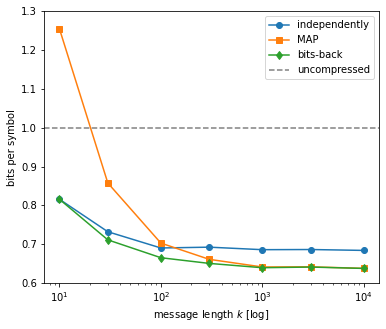

In [20]:
test_lengths = [10, 30, 100, 300, 1000, 3000, 10000]

bitrates_independently = [
    test_compression_method(encode_independently, decode_independently,
        message_length)
    for message_length in test_lengths]

bitrates_map = [
    test_compression_method(encode_map, decode_map, message_length)
    for message_length in test_lengths]

bitrates_bitsback = [
    test_compression_method(encode_bitsback, decode_bitsback, message_length)
    for message_length in test_lengths]

fig, ax = plt.subplots(figsize=(6, 5))
ax.set_xscale('log')
ax.plot(test_lengths, bitrates_independently, 'o-', label='independently')
ax.plot(test_lengths, bitrates_map, 's-', label='MAP')
ax.plot(test_lengths, bitrates_bitsback, 'd-', label='bits-back')
xlims = ax.get_xlim()
ax.plot(xlims, [1, 1], '--', color='gray', label='uncompressed')
ax.set_xlim(xlims)
ax.set_ylim(0.6, 1.3)
ax.set_xlabel('message length $k$ [log]')
ax.set_ylabel('bits per symbol')
ax.legend()

#### Your tasks:

You should be able to understand pretty much every aspect about the above plot.
Explain the following observations:

- Why do all methods become more effective (i.e., the bit rate per symbol drops) as the message length $k$ grows? (This is important to understand for the MAP and the bits-back method; for the "independent" method, it is just due to a small constant overhead of the ANS coder (about 16 to 32 bit), which becomes a bottleneck for very small $k$.)
- How is it possible that "compression" with the MAP method (orange curve) actually *increases* the file size over the uncompressed representation (dotted gray line) for very low $k$? (Hint: think about the extreme case of $k=1$: what does the MAP method transmit in this case?)
- Why does the compression performance of the MAP method (orange curve) approach the bits-back performance (green curve) in the limit $k\to\infty$?
- In the limit $k\to\infty$, all curves seem to converge to constant values, i.e., the bit rate per symbol no longer decreases as $k$ grows even further. What are these constants (express both of them as entropies or cross entropies of some probability distributions)?
  In particular, the fact that you were able to outperform the "independent" method (blue line)—which would be the *optimal* compression method if the symbols were statistically independent—demonstrates that the symbols $X_i$ that our latent variable model produces are *not* statistically independent (see also Problem 5.2 (d) on last week's problem set).

**Note:** if you decrease the message length below $k=10$ then you will get very noisy results because you'll then average over very little data (also, the coder has a small constant overhead of up to 32 bits in this limit, which becomes a bottleneck for very small $k$). Already in the above plot, the fact that the "bits-back" curve and the "independent" curve seem to meet at $k=10$ does not have any fundamental reason.